<center><h1><strong>AB Testing Customer Retention</strong></h1></center>

<br><br><br><br>

### **The Hypothesis** :

> - ##### **Offering a `10% discount` on the next month’s subscription will `reduce churn` by `20% in high-churn-risk customers`.** 

### **Hypothesis Testing** :
> **`Null Hypothesis (H₀)`: Offering a 10% discount does not reduce churn among high-risk customers.​**

> **`Alternative Hypothesis (H₁)`: Offering a 10% discount reduces churn among high-risk customers.**

### **Some Setup :**

In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
from scipy import stats

In [3]:
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.style.use("seaborn-v0_8")

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
from exploration.DataIngestion import DataIngestorFactory
from exploration.DataInspection import (DataInspector, DataTypesInspectionStrategy, DescriptiveStatsInspectionStrategy, DataShapeInspectionStrategy,
                             UniqueValuesInspectionStrategy, MissingValueInspectionStrategy, DuplicateRowInspectionStrategy, SkewnessInspectionStrategy)

### **Let's get our data :**

In [7]:
data_path = "../../data/ab_test_dataset.csv"
_, file_extension = os.path.splitext(data_path)

In [8]:
data_ingestor = DataIngestorFactory.get_data_ingestor(file_extension)
df = data_ingestor.ingest(data_path)
df.head()

,customer_id,is_high_risk,group,received_discount_offer,discount_amount,churned,tenure,monthly_charges,contract_type
0,1001,True,A,False,0.00,False,46,74.91,Month-to-month
1,1002,False,NaN,False,0.00,True,32,73.81,Month-to-month
2,1003,False,NaN,False,0.00,False,54,91.57,One year
3,1004,True,B,True,6.54,True,20,65.39,Month-to-month
4,1005,True,B,True,9.08,False,33,90.82,Month-to-month


#### **Data Shape** :

In [9]:
inspector = DataInspector(DataShapeInspectionStrategy())
inspector.execute_strategy(df)


Number of rows (observations): 365

Number of columns (features): 9


#### **Data Types :**

In [10]:
inspector.set_strategy(DataTypesInspectionStrategy())
inspector.execute_strategy(df)


Data Types and Non-null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              365 non-null    int64  
 1   is_high_risk             365 non-null    bool   
 2   group                    218 non-null    object 
 3   received_discount_offer  365 non-null    bool   
 4   discount_amount          365 non-null    float64
 5   churned                  365 non-null    bool   
 6   tenure                   365 non-null    int64  
 7   monthly_charges          365 non-null    float64
 8   contract_type            365 non-null    object 
dtypes: bool(3), float64(2), int64(2), object(2)
memory usage: 18.3+ KB
None


#### **Descriptive Statistics :**

In [11]:
inspector.set_strategy(DescriptiveStatsInspectionStrategy())
inspector.execute_strategy(df)


Descriptive Statistics (Numerical Features):
       customer_id  discount_amount      tenure  monthly_charges
count   365.000000       365.000000  365.000000       365.000000
mean   1183.000000         2.060164   35.082192        75.993808
std     105.510663         3.461045   20.107919        13.728615
min    1001.000000         0.000000    1.000000        50.130000
25%    1092.000000         0.000000   19.000000        65.810000
50%    1183.000000         0.000000   36.000000        76.820000
75%    1274.000000         5.520000   50.000000        87.530000
max    1365.000000         9.990000   71.000000        99.880000

Descriptive Statistics (Categorical Features):
       group   contract_type
count    218             365
unique     2               3
top        A  Month-to-month
freq     119             255


#### **Check Missing Values :**

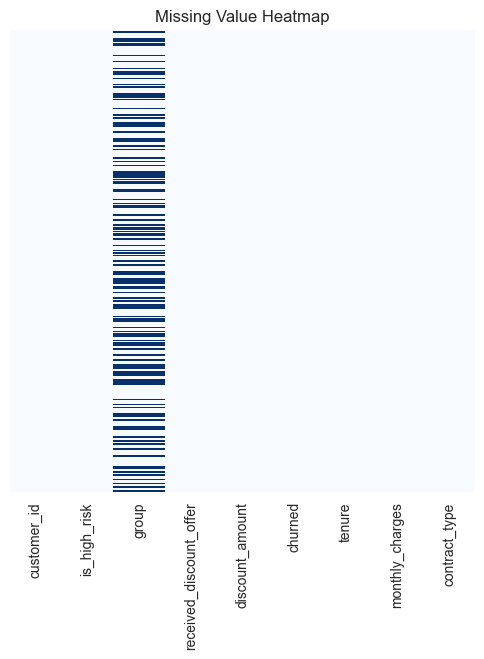

In [12]:
inspector.set_strategy(MissingValueInspectionStrategy())
inspector.execute_strategy(df)



> **This is because customers not labeled as high-risk were assigned 'N/A' for the group column**
> >  - The string 'N/A' is automatically interpreted as a missing value (NaN), we can treat 'N/A' as a normal string.

In [13]:
df['group'] = df['group'].fillna('N/A')
inspector.set_strategy(MissingValueInspectionStrategy())
inspector.execute_strategy(df)

Number of missing values = 0


#### **No. of Duplicated Rows** :

In [14]:
inspector.set_strategy(DuplicateRowInspectionStrategy())
inspector.execute_strategy(df)

nNumber of Duplicate Rows: 0


#### **Unique values** :

In [15]:
inspector.set_strategy(UniqueValuesInspectionStrategy())
inspector.execute_strategy(df)


Unique Values and Their Counts:

Column: customer_id
Number of unique values: 365

Column: is_high_risk
Number of unique values: 2
Unique Values: [ True False]

Column: group
Number of unique values: 3
Unique Values: ['A' 'N/A' 'B']

Column: received_discount_offer
Number of unique values: 2
Unique Values: [False  True]

Column: discount_amount
Number of unique values: 90

Column: churned
Number of unique values: 2
Unique Values: [False  True]

Column: tenure
Number of unique values: 71

Column: monthly_charges
Number of unique values: 344

Column: contract_type
Number of unique values: 3
Unique Values: ['Month-to-month' 'One year' 'Two year']


<br><br><br><br>

# **Let's start A/B Test --->**
#### **Data Balance Check :**

In [16]:
df['group'].value_counts()

group
N/A    147
A      119
B       99
Name: count, dtype: int64

> - **Not perfectly equal, but fairly close.**

### **Filter high-risk customers only (who are part of the A/B test)**
#### **Group A : Control Group who `did NOT` receive discount**
#### **Group B : Test Group who `did` receive discount**


In [17]:
df_ab = df[df['group'].isin(['A', 'B'])]

In [18]:
control_group = df_ab[(df_ab['group'] == 'A') & (df_ab['received_discount_offer'] == False)]
test_group = df_ab[(df_ab['group'] == 'B') & (df_ab['received_discount_offer'] == True)]

In [19]:
print("Control Group Size:", len(control_group))
print("Test Group Size:", len(test_group))

Control Group Size: 119
Test Group Size: 99


In [20]:
print("Control Group Sample:")
control_group.head()

Control Group Sample:


,customer_id,is_high_risk,group,received_discount_offer,discount_amount,churned,tenure,monthly_charges,contract_type
0,1001,True,A,False,0.0,False,46,74.91,Month-to-month
5,1006,True,A,False,0.0,True,40,98.40,One year
10,1011,True,A,False,0.0,False,33,71.03,Month-to-month
13,1014,True,A,False,0.0,False,66,90.25,Month-to-month
14,1015,True,A,False,0.0,True,38,95.16,One year


In [21]:
print("Test Group Sample:")
test_group.head()

Test Group Sample:


,customer_id,is_high_risk,group,received_discount_offer,discount_amount,churned,tenure,monthly_charges,contract_type
3,1004,True,B,True,6.54,True,20,65.39,Month-to-month
4,1005,True,B,True,9.08,False,33,90.82,Month-to-month
6,1007,True,B,True,5.44,False,32,54.42,Month-to-month
15,1016,True,B,True,8.09,False,46,80.86,Month-to-month
19,1020,True,B,True,7.77,False,61,77.74,Month-to-month


### **Track Churn Rates** :

In [32]:
control_churn_rate = control_group['churned'].mean()
test_churn_rate = test_group['churned'].mean()

print("Churn Rate\n-----------")
print("Control Group Churn Rate:", round(control_churn_rate, 4))
print("Test Group Churn Rate:", round(test_churn_rate, 4))


Churn Rate
-----------
Control Group Churn Rate: 0.4118
Test Group Churn Rate: 0.2323


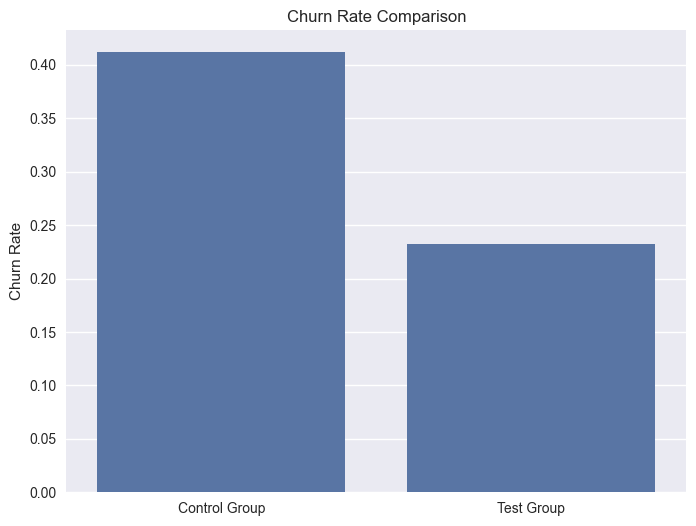

In [33]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Control Group', 'Test Group'], y=[control_churn_rate, test_churn_rate])
plt.ylabel('Churn Rate')
plt.title('Churn Rate Comparison')
plt.show()

> **Insights :**
> - **Control Group Churn Rate : 41.1%**
> - **Test Group Churn Rate : 23.2%** 
>> - **`The churn rate for the test group is substantially lower, suggesting the discount may have influenced customer retention.`**

### **Statistical Significance Testing** :

In [29]:
control_churn = control_group['churned'].astype(int)
test_churn = test_group['churned'].astype(int)

t_stat, p_value = stats.ttest_ind(
    control_churn,
    test_churn,
    equal_var=False
)

print("T-statistic:", round(t_stat, 4))
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The discount offer significantly reduces churn.")
else:
    print("Fail to reject the null hypothesis: No significant effect of the discount offer on churn.")


T-statistic: 2.8835
P-value: 0.0043306435961819306
Reject the null hypothesis: The discount offer significantly reduces churn.


> #### **`Final conclusion :`**
> - **The churn rate for the test group (23.2%) is substantially lower than that of the control group (41.1%).**
> - **The statistical test confirms this difference is significant (p < 0.05), meaning the 10% discount offer successfully reduces churn.**

### **`Action`:** **Consider rolling out the 10% discount offer to all high-risk customers to increase retention and customer lifetime value.**